In [20]:
# import statements
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import yfinance as yf
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.linear_model import LinearRegression
import statistics
pd.set_option('display.max_rows', 10000)
plt.style.use('ggplot')
%matplotlib inline

In [5]:
# create a dataframe object from the company information
stock_data = pd.read_excel('csds442_data2.xlsx', engine='openpyxl')
stock_data.columns =  ['Symbol','Treated', 'CompanyName', 'MarketCap','ShortPercent', 'Sector', 'TrailingEPS', 'Nov2020', 'Jan2021', 'BeforeTreatment', 'AfterTreatment']
stock_data['PriorThreeMonths'] = (stock_data['Jan2021'] - stock_data['Nov2020'])/stock_data['Nov2020']
stock_data['TreatmentChange'] = 100*((stock_data['AfterTreatment'] - stock_data['BeforeTreatment'])/stock_data['BeforeTreatment'])

# create a dataframe object from the mentions data from Swaggy Stocks
stock_data['Mentions'] = np.nan
mention_set = pd.read_csv('swaggy_data.csv')

# assign the value of mentions from the swaggy data to the original stock dataframe
for i in range(len(stock_data)):
    if stock_data['Symbol'].iloc[i] in list(mention_set['tk']):
        stock_data['Mentions'].iloc[i] = int(mention_set[mention_set['tk'] == stock_data['Symbol'].iloc[i]]['ment'].iloc[0])
        
t = stock_data[stock_data['Treated']==1]
nt = stock_data[stock_data['Treated']==0]
random_sel = nt.sample(159)
frames = [t, random_sel]
stock_data = pd.concat(frames)

# create dummy columns of the sectors that the stocks in the dataframe belong to
dummies = pd.get_dummies(stock_data['Sector'], drop_first=True)
stock_data = pd.concat([stock_data, dummies], axis=1)

In [8]:
# run logistic regression of the X random variables and see how they affect the Y (treated) variable
logreg = LogisticRegression()
X = stock_data[['MarketCap', 'ShortPercent', 'PriorThreeMonths', 'Consumer Cyclical', 'Consumer Defensive', 'Energy', 'Financial Services', 'Healthcare', 'Industrials', 'Real Estate', 'Technology', 'Utilities']]
X = X.fillna(X.median())
y = stock_data[['Treated']]
a = logreg.fit(X, y)

/home/ctt0/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


In [9]:
# in order to get the propensity scores for the treated, predict the probability using the logistic regression
# model that the output will be 1
stock_data['PropensityForTreatment']=a.predict_proba(X)[:,1]

In [10]:
# find the proportion of treated and untreated values
prob_no_treatment = stock_data['Treated'].value_counts()[0] / len(stock_data)
prob_treatment = stock_data['Treated'].value_counts()[1] / len(stock_data)

In [11]:
# set the weight for each observation 
stock_data['Weight'] = np.nan
for i in range(len(stock_data)):
    if stock_data['Treated'].iloc[i] == 1:
        stock_data['Weight'].iloc[i] = 1 / stock_data['PropensityForTreatment'].iloc[i]
    else:
        stock_data['Weight'].iloc[i] = 1 / (1 - stock_data['PropensityForTreatment'].iloc[i])

/home/ctt0/.local/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
# run linear regression 
model = LinearRegression()
X_treatment =np.array(list( stock_data['Treated'])).reshape(-1, 1)
y_result = np.array(list(stock_data['TreatmentChange'])).reshape(-1, 1)
model.fit(X_treatment, y_result)

WLS = LinearRegression()
WLS.fit(X_treatment, y_result, sample_weight=list(stock_data['Weight']))


beta_0_orig = model.intercept_[0]
beta_1_orig = model.coef_[0][0]

beta_0_wls = WLS.intercept_[0]
beta_1_wls = WLS.coef_[0][0]

In [14]:
# find the original versus updated ACE after ipw
result_orig = 'Beta_0 = ' + str(round(beta_0_orig,3)) + ' and Beta_1 = ' + str(round(beta_1_orig,3))
result_ipw = 'Beta_0 = ' + str(round(beta_0_wls,3)) + ' and Beta_1 = ' + str(round(beta_1_wls,3))

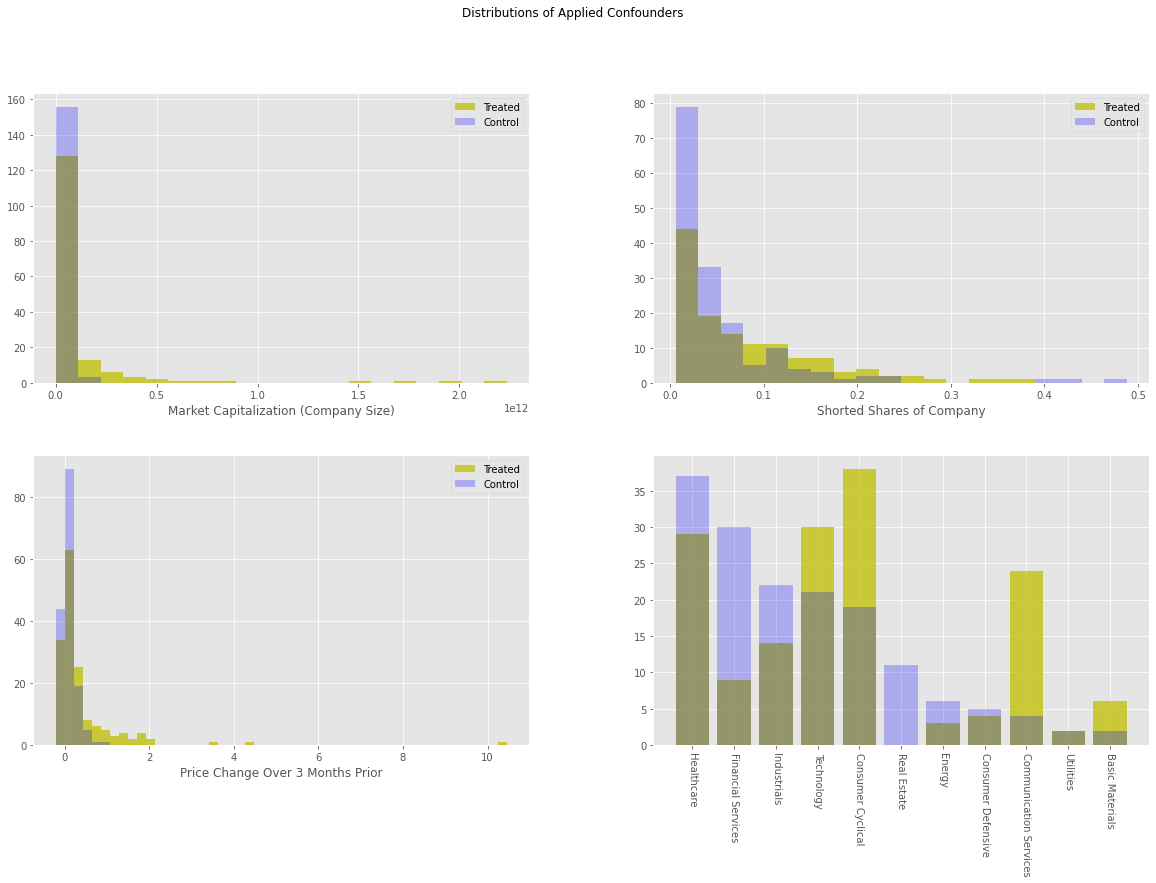

In [15]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 12)

fig.suptitle('Distributions of Applied Confounders')

plt.subplot(2,2,1)
cap_treatment = list(stock_data[stock_data['Treated'] == 1]['MarketCap'])
c1 = cap_treatment
cap_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['MarketCap'])
c2 = cap_no_treatment

bins=np.histogram(np.hstack((c1,c2)), bins=20)[1] 


plt.hist(c1, bins, alpha = .75, label = 'Treated',color = 'y')
plt.hist(c2, bins, alpha = .25, label = 'Control',color =  'b')
plt.legend()
plt.xlabel('Market Capitalization (Company Size)')



plt.subplot(2,2,2)
short_treatment = list(stock_data[stock_data['Treated'] == 1]['ShortPercent'])
short_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['ShortPercent'])

cleanedListTreat = [x for x in short_treatment if str(x) != 'nan']
cleanedListNoTreat = [x for x in short_no_treatment if str(x) != 'nan']

s1 = cleanedListTreat
s2 = cleanedListNoTreat

bins=np.histogram(np.hstack((s1,s2)), bins=20)[1] 


plt.hist(s1, bins, alpha = .75, label = 'Treated',color = 'y')
plt.hist(s2, bins, alpha = .25, label = 'Control',color =  'b')
plt.legend()
plt.xlabel('Shorted Shares of Company')

plt.subplot(2,2,3)
three_treatment = list(stock_data[stock_data['Treated'] == 1]['PriorThreeMonths'])
three_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['PriorThreeMonths'])

three_treatment_clean = [x for x in three_treatment if str(x) != 'nan']
three_no_treatment_clean = [x for x in three_no_treatment if str(x) != 'nan']

p1 = three_treatment_clean
p2 = three_no_treatment_clean

bins=np.histogram(np.hstack((p1,p2)), bins=50)[1] 


plt.hist(p1, bins, alpha = .75, label = 'Treated',color = 'y')
plt.hist(p2, bins, alpha = .25, label = 'Control',color =  'b')
plt.legend()
plt.xlabel('Price Change Over 3 Months Prior')

plt.subplot(2,2,4)
sec_treat = stock_data[stock_data['Treated']==1]['Sector'].value_counts()
sec_control = stock_data[stock_data['Treated']==0]['Sector'].value_counts()

sec_index = list(sec_control.index)
cnt_treat = []
cnt_control = []
for s in sec_index:
    try:
        cnt_treat.append(sec_treat[s])
    except:
        cnt_treat.append(0)
    cnt_control.append(sec_control[s])

plt.bar(sec_index, cnt_treat,alpha = .75, label = 'Treated',color = 'y')
plt.bar(sec_index, cnt_control, alpha = .25, label = 'Control',color =  'b')
plt.xticks(rotation=-90)

fig.subplots_adjust(wspace=.25, hspace=.25)

Text(0.5, 0, 'Weighting')

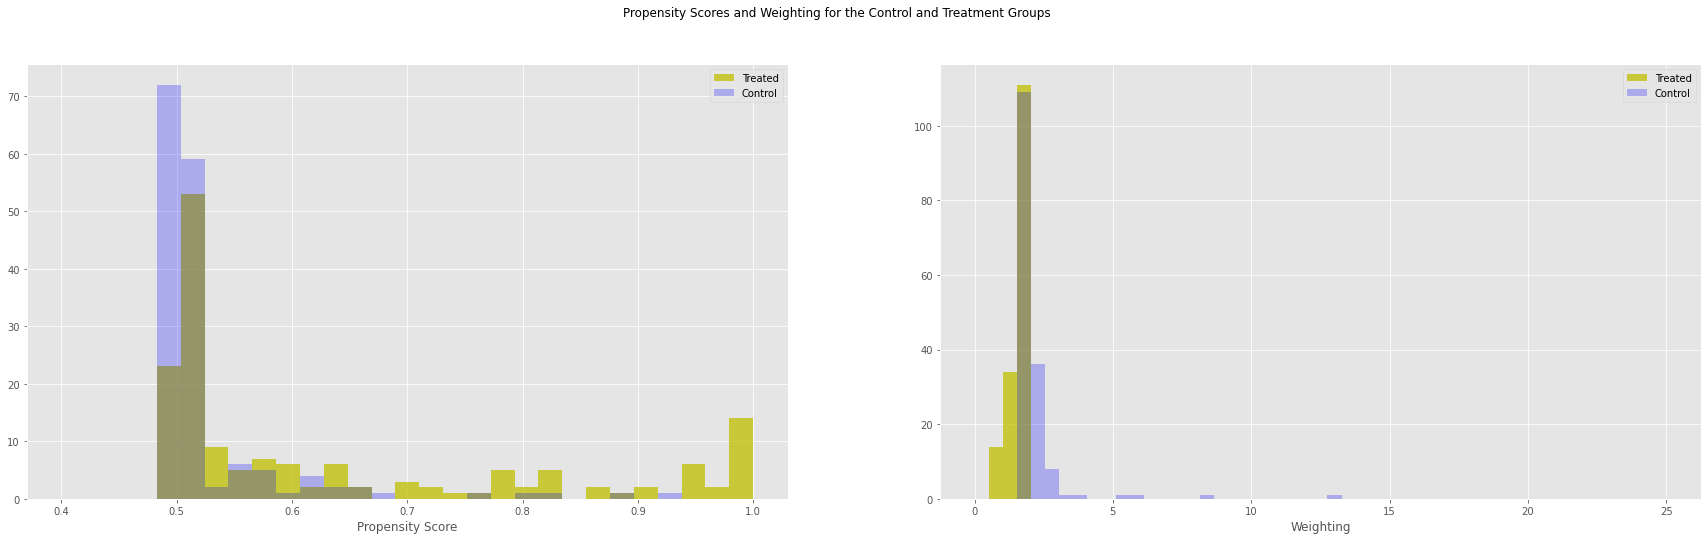

In [16]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(30, 8)

fig.suptitle('Propensity Scores and Weighting for the Control and Treatment Groups')

plt.subplot(1,2,1)
prop_treatment = list(stock_data[stock_data['Treated'] == 1]['PropensityForTreatment'])
prop_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['PropensityForTreatment'])
y1 = prop_treatment
y2 = prop_no_treatment

bins = np.linspace(.4, 1, 30)

plt.hist(y1, bins, alpha = .75, label = 'Treated',color = 'y')
plt.hist(y2, bins, alpha = .25, label = 'Control',color =  'b')
plt.legend()
plt.xlabel('Propensity Score')

plt.subplot(1,2,2)
weight_treatment = list(stock_data[stock_data['Treated'] == 1]['Weight'])
weight_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['Weight'])
w1 = weight_treatment
w2 = weight_no_treatment

bins = np.linspace(0, 25, 50)

plt.hist(w1, bins, alpha = .75, label = 'Treated',color = 'y')
plt.hist(w2, bins, alpha = .25, label = 'Control',color =  'b')
plt.legend()
plt.xlabel('Weighting')

Text(0, 0.5, 'Outcome of Return')

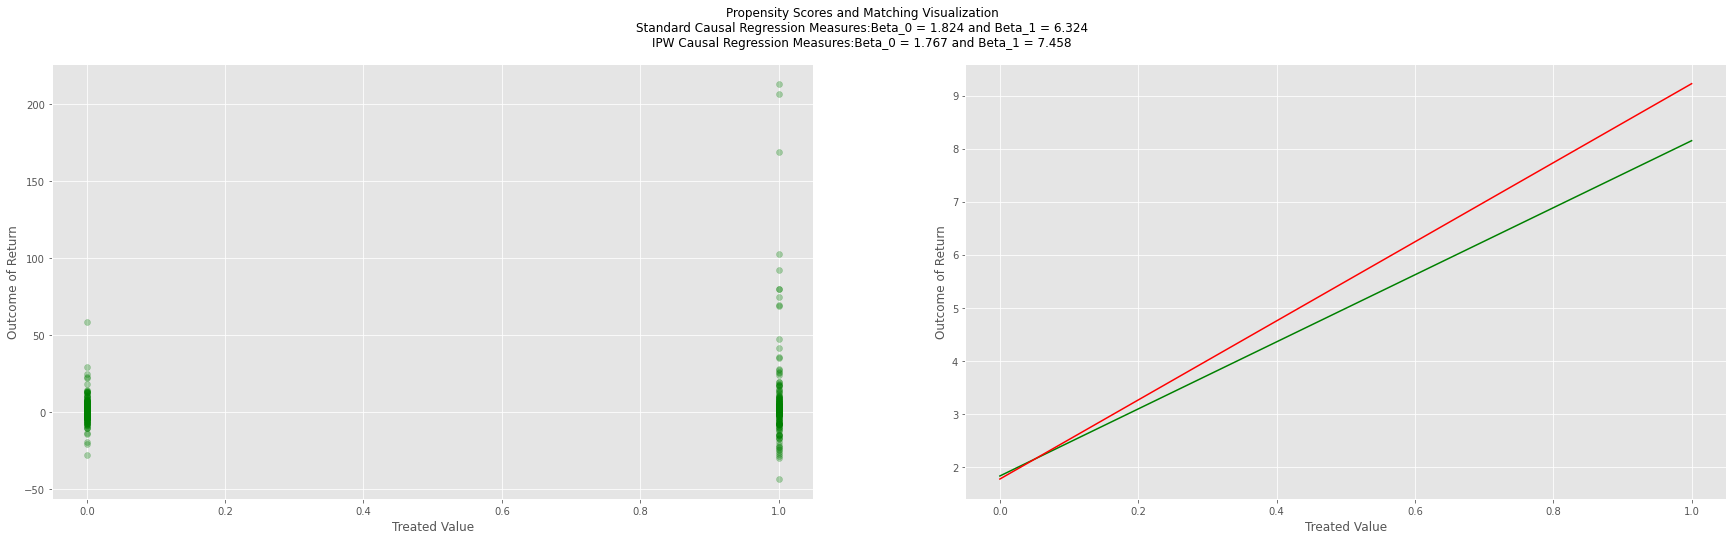

In [17]:
plt.figure()
fig = plt.gcf()
fig.set_size_inches(30, 8)

fig.suptitle('Propensity Scores and Matching Visualization\nStandard Causal Regression Measures:' + result_orig + '\nIPW Causal Regression Measures:' + result_ipw)

plt.subplot(1,2,1)
plt.scatter(stock_data['Treated'], stock_data['TreatmentChange'], alpha =.3, color = 'g')
plt.xlabel('Treated Value')
plt.ylabel('Outcome of Return')

plt.subplot(1,2,2)
treat_space = np.linspace(0,1,5)
exp_y_orig = beta_0_orig + beta_1_orig * treat_space
exp_y_wls = beta_0_wls + beta_1_wls * treat_space
plt.plot(treat_space, exp_y_orig, color ='g')
plt.plot(treat_space, exp_y_wls, color ='r')

plt.xlabel('Treated Value')
plt.ylabel('Outcome of Return')


In [26]:
# in order to acquire more accurate ACE, bootstrap the data
def bootstrap(dataframe, run_count, standard):
    alpha_0_list = []
    alpha_1_list = []
    for i in range(run_count):
        sample = dataframe.sample(int(len(dataframe)/5))
        model = LinearRegression()
        
        X_treatment =np.array(list(sample['Treated'])).reshape(-1, 1)
        y_result = np.array(list(sample['TreatmentChange'])).reshape(-1, 1)
        
        # if we are using standardization, no weights are needed. If IPW, add weights
        if standard:
            model.fit(X_treatment, y_result)
        else:
            model.fit(X_treatment, y_result, sample_weight=list(sample['Weight']))

        alpha_0_list.append(model.intercept_[0])
        alpha_1_list.append(model.coef_[0][0])
        
    return(alpha_0_list, alpha_1_list)

(array([  6.,  45., 196., 268., 209., 154.,  76.,  30.,  12.,   4.]),
 array([-8.34385555, -4.85418418, -1.3645128 ,  2.12515857,  5.61482994,
         9.10450132, 12.59417269, 16.08384407, 19.57351544, 23.06318682,
        26.55285819]),
 <BarContainer object of 10 artists>)

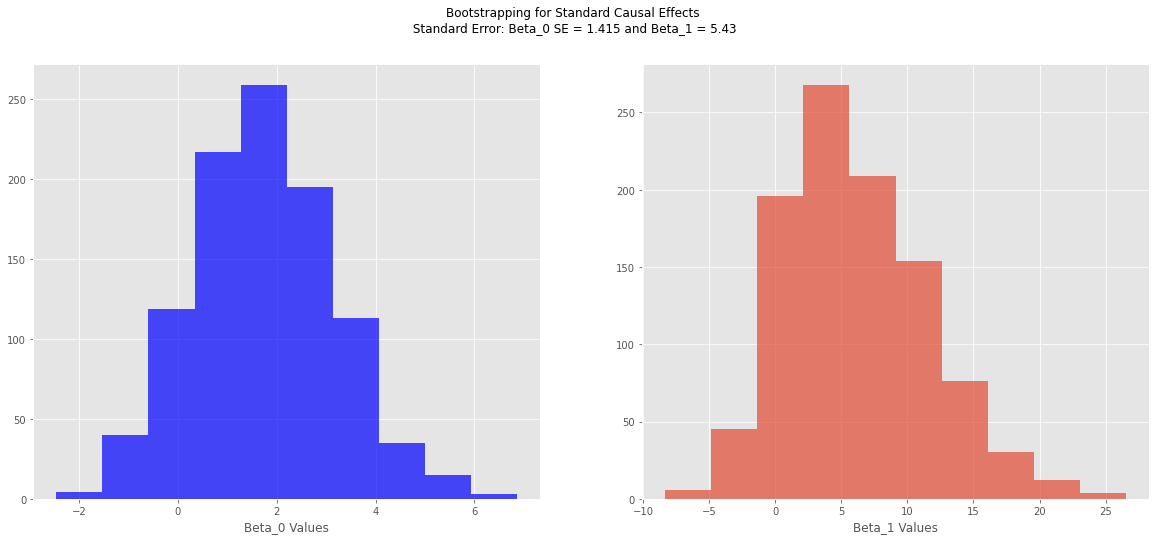

In [27]:
alpha_0, alpha_1 = bootstrap(stock_data,1000, True)
b0_se = statistics.stdev(alpha_0)
b1_se = statistics.stdev(alpha_1)
se_orig = 'Beta_0 SE = ' + str(round(b0_se,3)) + ' and Beta_1 = ' + str(round(b1_se,3))

plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 8)

fig.suptitle('Bootstrapping for Standard Causal Effects\n Standard Error: ' + se_orig)

plt.subplot(1,2,1)
plt.xlabel('Beta_0 Values')
plt.hist(alpha_0, alpha= .7, color = 'b')

plt.subplot(1,2,2)
plt.xlabel('Beta_1 Values')
plt.hist(alpha_1, alpha = .7)

(array([ 19., 106., 215., 217., 214., 132.,  67.,  15.,  13.,   2.]),
 array([-7.67469111, -3.68467785,  0.3053354 ,  4.29534866,  8.28536191,
        12.27537516, 16.26538842, 20.25540167, 24.24541493, 28.23542818,
        32.22544143]),
 <BarContainer object of 10 artists>)

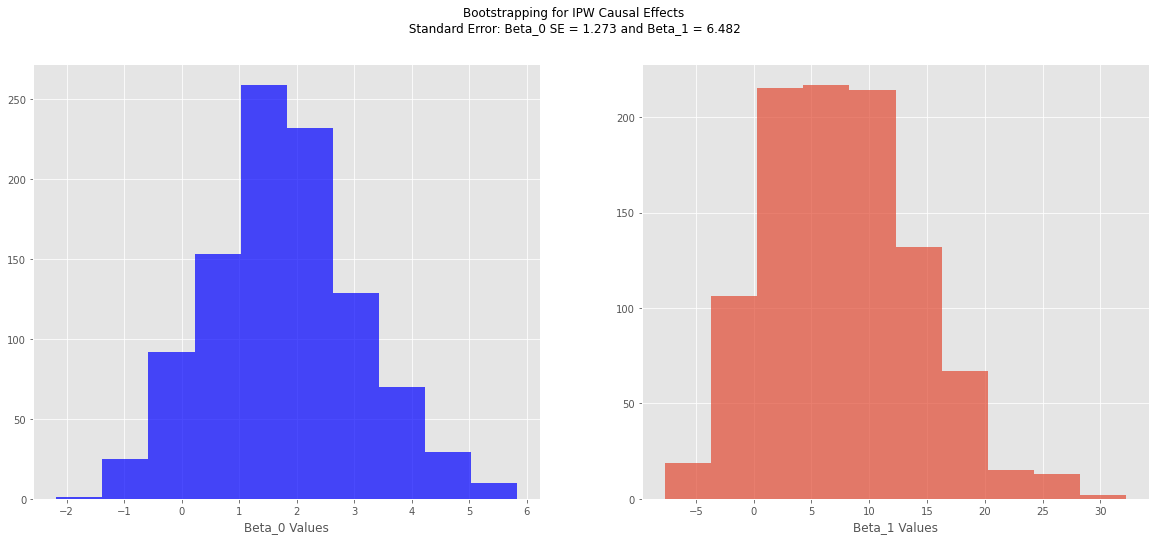

In [28]:
alpha_0, alpha_1 = bootstrap(stock_data,1000, False)
b0_se = statistics.stdev(alpha_0)
b1_se = statistics.stdev(alpha_1)
se_ipw = 'Beta_0 SE = ' + str(round(b0_se,3)) + ' and Beta_1 = ' + str(round(b1_se,3))

plt.figure()
fig = plt.gcf()
fig.set_size_inches(20, 8)

fig.suptitle('Bootstrapping for IPW Causal Effects\n Standard Error: ' + se_ipw)

plt.subplot(1,2,1)
plt.xlabel('Beta_0 Values')
plt.hist(alpha_0, alpha= .7, color = 'b')

plt.subplot(1,2,2)
plt.xlabel('Beta_1 Values')
plt.hist(alpha_1, alpha = .7)

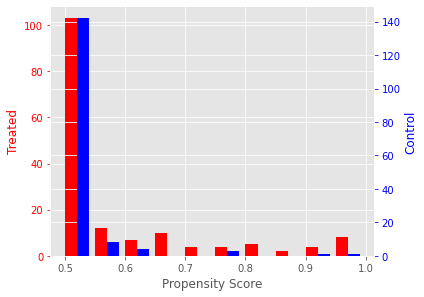

In [154]:
# 


In [170]:
# weight_treatment = list(stock_data[stock_data['Treated'] == 1]['Weight'])
# weight_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['Weight'])
# y1 = weight_treatment
# y2 = weight_no_treatment
# colors = ['r', 'b']


# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.hist([y1, y2], color=colors)
# n, bins, patches = ax1.hist([y1,y2])
# ax1.cla() #clear the axis

# #plots the histogram data
# width = (bins[1] - bins[0]) * 0.4
# bins_shifted = bins + width
# ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
# ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

# #finishes the plot
# ax1.set_ylabel("Treated", color=colors[0])
# ax2.set_ylabel("Control", color=colors[1])
# ax1.tick_params('y', colors=colors[0])
# ax2.tick_params('y', colors=colors[1])
# plt.tight_layout()
# ax1.set_xlabel('Weights')
# plt.show()

In [19]:
# cap_treatment = list(stock_data[stock_data['Treated'] == 1]['MarketCap'])
# cap_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['MarketCap'])
# y1 = cap_treatment
# y2 = cap_no_treatment
# colors = ['r', 'b']


# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.hist([y1, y2], color=colors)
# n, bins, patches = ax1.hist([y1,y2])
# ax1.cla() #clear the axis

# #plots the histogram data
# width = (bins[1] - bins[0]) * 0.4
# bins_shifted = bins + width
# ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
# ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

# #finishes the plot
# ax1.set_ylabel("Treated", color=colors[0])
# ax2.set_ylabel("Control", color=colors[1])
# ax1.tick_params('y', colors=colors[0])
# ax2.tick_params('y', colors=colors[1])
# plt.tight_layout()
# ax1.set_xlabel('Market Cap')
# plt.show()

In [26]:
# short_treatment = list(stock_data[stock_data['Treated'] == 1]['ShortPercent'])
# short_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['ShortPercent'])
# y1 = short_treatment
# y2 = short_no_treatment
# colors = ['r', 'b']


# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.hist([y1, y2], color=colors)
# n, bins, patches = ax1.hist([y1,y2])
# ax1.cla() #clear the axis

# #plots the histogram data
# width = (bins[1] - bins[0]) * 0.4
# bins_shifted = bins + width
# ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
# ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

# #finishes the plot
# ax1.set_ylabel("Treated", color=colors[0])
# ax2.set_ylabel("Control", color=colors[1])
# ax1.tick_params('y', colors=colors[0])
# ax2.tick_params('y', colors=colors[1])
# plt.tight_layout()
# plt.xlabel('Short Percent')
# plt.show()

In [31]:
# three_treatment = list(stock_data[stock_data['Treated'] == 1]['PriorThreeMonths'])
# three_no_treatment =  list(stock_data[stock_data['Treated'] == 0]['PriorThreeMonths'])
# y1 = three_treatment
# y2 = three_no_treatment
# colors = ['r', 'b']


# fig, ax1 = plt.subplots()
# ax2 = ax1.twinx()
# ax1.hist([y1, y2], color=colors)
# n, bins, patches = ax1.hist([y1,y2])
# ax1.cla() #clear the axis

# #plots the histogram data
# width = (bins[1] - bins[0]) * 0.4
# bins_shifted = bins + width
# ax1.bar(bins[:-1], n[0], width, align='edge', color=colors[0])
# ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color=colors[1])

# #finishes the plot
# ax1.set_ylabel("Treated", color=colors[0])
# ax2.set_ylabel("Control", color=colors[1])
# ax1.tick_params('y', colors=colors[0])
# ax2.tick_params('y', colors=colors[1])
# plt.tight_layout()
# plt.xlabel('Trailing EPS')
# plt.show()

In [76]:
# #INTERVALUES FOR SHORT VALUES
# treated = stock_data[stock_data['Treated'] == 1]
# nontreated = stock_data[stock_data['Treated'] == 0]
# confidence_wsb =  [treated['ShortPercent'].mean() - 2 *( (treated['ShortPercent'].std()) / len(treated)),treated['ShortPercent'].mean() + 2 * ((treated['ShortPercent'].std()) / len(treated))]
# confidence_nonwsb =  [nontreated['ShortPercent'].mean() - 2 *( (nontreated['ShortPercent'].std()) / len(nontreated)),nontreated['ShortPercent'].mean() + 2 * ((nontreated['ShortPercent'].std()) / len(nontreated))]
# print(confidence_wsb)
# print(confidence_nonwsb)